### 6. GBDT Model Training and Test

In [1]:
# import libraries used

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  OneHotEncoder, LabelEncoder

import swifter
import gc

In [2]:
# Load processed dataset.

data = pd.read_pickle('v30_data.pkl')

In [3]:
# train, validation, test data set parameter setting.

test_date_block = 34
val_date_block = test_date_block - 1
train_date_block = val_date_block - 1

In [4]:
# load missing 
#df_missing = pd.read_csv("missing_replace.csv", sep=',')

In [5]:
#for index, row in df_missing.iterrows():
#    data.loc[data.item_id == row.item_id, 'item_id'] = row.rep_id

In [6]:
#data

#### 6.1 On Sale Model Training

#### 6.1.1 All Samples Model

In [7]:
on_sale_data = data.copy()

In [8]:
drop_list_on_sale = [
    'days',
    'shop_city',
    'avg_date_city_item_cnt_lag_1',
    'avg_date_city_item_cnt_lag_2',
    'avg_date_city_item_cnt_lag_3',
    'shop_item_on_market',
    #'shop_item_no_sale',
    #'avg_date_item_price_cnt_lag_1',
    'avg_date_item_price_cnt_lag_2',
    'avg_date_item_price_cnt_lag_3',
    #'avg_date_shop_item_price_cnt_lag_1',
    'avg_date_shop_item_price_cnt_lag_2',
    'avg_date_shop_item_price_cnt_lag_3',
    'avg_date_cat_price_cnt_lag_1',
    'avg_date_cat_price_cnt_lag_2',
    'avg_date_cat_price_cnt_lag_3',
    'avg_date_shop_cat_price_cnt_lag_1',
    'avg_date_shop_cat_price_cnt_lag_2',
    'avg_date_shop_cat_price_cnt_lag_3',
    'date_item_price_lag_2',
    'date_item_price_lag_3',
    'date_shop_item_price_lag_2',
    'date_shop_item_price_lag_3',
    #'date_shop_revenue_lag_1',
    'date_shop_revenue_lag_2',
    'date_shop_revenue_lag_3',
    #'date_shop_cat_revenue_lag_1',
    'date_shop_cat_revenue_lag_2',
    'date_shop_cat_revenue_lag_3',
]

on_sale_data.drop(drop_list_on_sale, axis=1, inplace=True)

In [9]:
#just extract the samples within the test dataset
'''
shop_list = list(on_sale_data[on_sale_data.date_block_num == test_date_block].shop_id.unique())
item_list = list(on_sale_data[on_sale_data.date_block_num == test_date_block].item_id.unique())

on_sale_data = on_sale_data[on_sale_data.shop_id.isin(shop_list)]
on_sale_data = on_sale_data[on_sale_data.item_id.isin(item_list)]
'''

'\nshop_list = list(on_sale_data[on_sale_data.date_block_num == test_date_block].shop_id.unique())\nitem_list = list(on_sale_data[on_sale_data.date_block_num == test_date_block].item_id.unique())\n\non_sale_data = on_sale_data[on_sale_data.shop_id.isin(shop_list)]\non_sale_data = on_sale_data[on_sale_data.item_id.isin(item_list)]\n'

In [10]:
#on_sale_data_ft = on_sale_data[on_sale_data.time_on_market > 0]
on_sale_data_ft = on_sale_data.copy()

In [11]:
X_train_on_sale = on_sale_data_ft[(on_sale_data_ft.date_block_num <= train_date_block)].drop(['date_shop_item_cnt'], axis=1)
Y_train_on_sale = on_sale_data_ft[(on_sale_data_ft.date_block_num <= train_date_block)]['date_shop_item_cnt']
X_valid_on_sale = on_sale_data_ft[(on_sale_data_ft.date_block_num == val_date_block)].drop(['date_shop_item_cnt'], axis=1)
Y_valid_on_sale = on_sale_data_ft[(on_sale_data_ft.date_block_num == val_date_block)]['date_shop_item_cnt']

In [12]:
import lightgbm as lgb

dt = lgb.Dataset(X_train_on_sale, Y_train_on_sale)
dv = lgb.Dataset(X_valid_on_sale, Y_valid_on_sale)

params = {'metric': 'rmse',
          'boosting':'gbdt',
          'num_leaves': 255,
          'learning_rate': 0.1,
          'num_iterations':250,
          'feature_fraction': 0.7,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'min_split_gain':1,
          'force_col_wise' : True,
          'max_depth' : 10,
          'min_data_in_leaf':100,
          'max_bin':255,
          'early_stopping_rounds':100,
          'n_estimators':100,
          'random_state': 10
}

features = [
    'date_block_num',
    'shop_id',
    #'shop_city',
    'shop_type',
    'item_category_id', 
    'cat_type',
    'sub_type',
    'month',
]

lgb_on_sale = lgb.train(params=params,
                      train_set=dt,
                      valid_sets=(dt, dv),
                      categorical_feature=features,
                      verbose_eval=100)      

/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_type', 'date_block_n

[LightGBM] [Info] Total Bins 9275
[LightGBM] [Info] Number of data points in the train set: 10674594, number of used features: 71


/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/shirong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.298607
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

<Figure size 864x432 with 0 Axes>

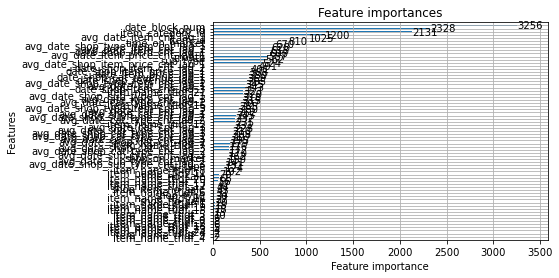

In [13]:
import matplotlib.pylab as plt


plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_on_sale)
plt.title("Feature importances")
plt.show()


#### 6.3 Validation

In [14]:
X_valid_on_sale = on_sale_data[(on_sale_data.date_block_num == val_date_block)].drop(['date_shop_item_cnt'], axis=1)
X_valid_on_sale_ft = X_valid_on_sale.copy()

In [15]:
#Y_pred_on_sale_lgb = lgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)
#Y_pred_on_sale_xgb = xgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)
#Y_pred_on_sale = 0.67*Y_pred_on_sale_lgb + 0.33*Y_pred_on_sale_xgb
#Y_pred_on_sale = ridge_on_sale.predict(X_valid_on_sale_ft).clip(0,20)[:,2]

Y_pred_on_sale = lgb_on_sale.predict(X_valid_on_sale_ft).clip(0,20)

X_valid_on_sale = X_valid_on_sale[['shop_id', 'item_id']]
X_valid_on_sale['Y_pred_on_sale'] = Y_pred_on_sale
X_valid_on_sale

,shop_id,item_id,Y_pred_on_sale
10674594,2,30,0.012263
10674595,2,31,0.053467
10674596,2,32,0.155542
10674597,2,33,0.232436
10674598,2,40,0.000000
...,...,...,...
10912761,59,22162,0.085380
10912762,59,22163,0.147835
10912763,59,22164,0.131358
10912764,59,22166,0.000000


In [16]:
Y_valid = data[data.date_block_num == val_date_block]
Y_valid

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,avg_date_shop_cat_price_cnt_lag_2,avg_date_shop_cat_price_cnt_lag_3,date_shop_revenue_lag_1,date_shop_revenue_lag_2,date_shop_revenue_lag_3,date_shop_cat_revenue_lag_1,date_shop_cat_revenue_lag_2,date_shop_cat_revenue_lag_3,month,days
10674594,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,0.0,0.0,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31
10674595,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,0.0,0.0,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31
10674596,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,0.0,0.0,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31
10674597,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,0.0,0.0,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31
10674598,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,0.0,0.0,1257.0,986.0,987.0,0.000000,0.000000,0.000000,9,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912761,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,0.0,0.0,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31
10912762,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,0.0,0.0,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31
10912763,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,0.0,0.0,1097.0,939.0,855.0,18.828125,21.921875,22.687500,9,31
10912764,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,0.0,0.0,1097.0,939.0,855.0,0.000000,0.000000,0.000000,9,31


In [17]:
Y_valid = pd.merge(Y_valid, X_valid_on_sale, on=['shop_id', 'item_id'], how='left')
Y_valid

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,avg_date_shop_cat_price_cnt_lag_3,date_shop_revenue_lag_1,date_shop_revenue_lag_2,date_shop_revenue_lag_3,date_shop_cat_revenue_lag_1,date_shop_cat_revenue_lag_2,date_shop_cat_revenue_lag_3,month,days,Y_pred_on_sale
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,0.0,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.012263
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,0.0,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.053467
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,0.0,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.155542
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,0.0,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.232436
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,0.0,1257.0,986.0,987.0,0.000000,0.000000,0.000000,9,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,0.0,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.085380
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,0.0,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.147835
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,0.0,1097.0,939.0,855.0,18.828125,21.921875,22.687500,9,31,0.131358
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,0.0,1097.0,939.0,855.0,0.000000,0.000000,0.000000,9,31,0.000000


In [18]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_valid['date_shop_item_cnt'], Y_valid['Y_pred_on_sale']))

print("The final rmse is {}".format(rmse))

The final rmse is 0.8600249938722156


#### 6.5 Error Analysis

#### 6.5.1 RMSE Calculation

In [19]:
df_item_id_rmse = Y_valid[['item_id', 'date_shop_item_cnt', 'Y_pred_on_sale']].reset_index(drop=True)
item_id_rmse = [-1] * (Y_valid.item_id.max() + 1)

for index, row in df_item_id_rmse.iterrows():
    if item_id_rmse[int(row.item_id)] == -1:
        item_id_rmse[int(row.item_id)] = np.sqrt(mean_squared_error(
            df_item_id_rmse[df_item_id_rmse.item_id == row.item_id]['date_shop_item_cnt'], 
            df_item_id_rmse[df_item_id_rmse.item_id == row.item_id]['Y_pred_on_sale']
        ))

def apply_item_id_rmse(row):
    return item_id_rmse[int(row.item_id)]

Y_valid['item_id_rmse'] = Y_valid.swifter.apply(apply_item_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,date_shop_revenue_lag_1,date_shop_revenue_lag_2,date_shop_revenue_lag_3,date_shop_cat_revenue_lag_1,date_shop_cat_revenue_lag_2,date_shop_cat_revenue_lag_3,month,days,Y_pred_on_sale,item_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.012263,0.129395
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.053467,0.666504
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,1257.0,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.155542,0.640625
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,1257.0,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.232436,0.481934
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,1257.0,986.0,987.0,0.000000,0.000000,0.000000,9,31,0.000000,0.107178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.085380,0.465332
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,1097.0,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.147835,0.764160
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,1097.0,939.0,855.0,18.828125,21.921875,22.687500,9,31,0.131358,0.672852
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,1097.0,939.0,855.0,0.000000,0.000000,0.000000,9,31,0.000000,0.624023


In [20]:
df_shop_id_rmse = Y_valid[['shop_id', 'date_shop_item_cnt', 'Y_pred_on_sale']].reset_index(drop=True)
shop_id_rmse = [-1] * (Y_valid.shop_id.max() + 1)

for index, row in df_shop_id_rmse.iterrows():
    if shop_id_rmse[int(row.shop_id)] == -1:
        shop_id_rmse[int(row.shop_id)] = np.sqrt(mean_squared_error(
            df_shop_id_rmse[df_shop_id_rmse.shop_id == row.shop_id]['date_shop_item_cnt'], 
            df_shop_id_rmse[df_shop_id_rmse.shop_id == row.shop_id]['Y_pred_on_sale']
        ))

def apply_shop_id_rmse(row):
    return shop_id_rmse[int(row.shop_id)]

Y_valid['shop_id_rmse'] = Y_valid.swifter.apply(apply_shop_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,date_shop_revenue_lag_2,date_shop_revenue_lag_3,date_shop_cat_revenue_lag_1,date_shop_cat_revenue_lag_2,date_shop_cat_revenue_lag_3,month,days,Y_pred_on_sale,item_id_rmse,shop_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.012263,0.129395,0.575684
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.053467,0.666504,0.575684
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,986.0,987.0,11.531250,18.203125,17.421875,9,31,0.155542,0.640625,0.575684
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,986.0,987.0,19.828125,17.687500,10.820312,9,31,0.232436,0.481934,0.575684
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,986.0,987.0,0.000000,0.000000,0.000000,9,31,0.000000,0.107178,0.575684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.085380,0.465332,0.514160
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,939.0,855.0,26.859375,23.781250,24.171875,9,31,0.147835,0.764160,0.514160
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,939.0,855.0,18.828125,21.921875,22.687500,9,31,0.131358,0.672852,0.514160
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,939.0,855.0,0.000000,0.000000,0.000000,9,31,0.000000,0.624023,0.514160


In [21]:
df_cat_id_rmse = Y_valid[['item_category_id', 'date_shop_item_cnt', 'Y_pred_on_sale']].reset_index(drop=True)
cat_id_rmse = [-1] * (Y_valid.item_category_id.max() + 1)

for index, row in df_cat_id_rmse.iterrows():
    if cat_id_rmse[int(row.item_category_id)] == -1:
        cat_id_rmse[int(row.item_category_id)] = np.sqrt(mean_squared_error(
            df_cat_id_rmse[df_cat_id_rmse.item_category_id == row.item_category_id]['date_shop_item_cnt'], 
            df_cat_id_rmse[df_cat_id_rmse.item_category_id == row.item_category_id]['Y_pred_on_sale']
        ))

def apply_cat_id_rmse(row):
    return cat_id_rmse[int(row.item_category_id)]

Y_valid['cat_id_rmse'] = Y_valid.swifter.apply(apply_cat_id_rmse, axis=1).astype(np.float16) 
Y_valid

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,date_block_num,shop_id,item_id,shop_city,shop_type,item_category_id,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,...,date_shop_revenue_lag_3,date_shop_cat_revenue_lag_1,date_shop_cat_revenue_lag_2,date_shop_cat_revenue_lag_3,month,days,Y_pred_on_sale,item_id_rmse,shop_id_rmse,cat_id_rmse
0,33,2,30,1,7,40,0.000000,0.0,0.0,0.0,...,987.0,11.531250,18.203125,17.421875,9,31,0.012263,0.129395,0.575684,0.632812
1,33,2,31,1,7,37,0.000000,0.0,0.0,1.0,...,987.0,19.828125,17.687500,10.820312,9,31,0.053467,0.666504,0.575684,0.729492
2,33,2,32,1,7,40,0.000000,0.0,0.0,0.0,...,987.0,11.531250,18.203125,17.421875,9,31,0.155542,0.640625,0.575684,0.632812
3,33,2,33,1,7,37,0.000000,0.0,0.0,1.0,...,987.0,19.828125,17.687500,10.820312,9,31,0.232436,0.481934,0.575684,0.729492
4,33,2,40,1,7,57,0.000000,0.0,0.0,0.0,...,987.0,0.000000,0.000000,0.000000,9,31,0.000000,0.107178,0.575684,0.260010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238167,33,59,22162,32,7,40,0.000000,0.0,0.0,0.0,...,855.0,26.859375,23.781250,24.171875,9,31,0.085380,0.465332,0.514160,0.632812
238168,33,59,22163,32,7,40,0.000000,0.0,0.0,0.0,...,855.0,26.859375,23.781250,24.171875,9,31,0.147835,0.764160,0.514160,0.632812
238169,33,59,22164,32,7,37,0.000000,0.0,0.0,1.0,...,855.0,18.828125,21.921875,22.687500,9,31,0.131358,0.672852,0.514160,0.729492
238170,33,59,22166,32,7,54,0.672513,0.0,0.0,0.0,...,855.0,0.000000,0.000000,0.000000,9,31,0.000000,0.624023,0.514160,0.470947


In [22]:
Y_valid.to_csv('v30_rmse_lgb_nr_m1.csv', index=False)

In [23]:
shop_id_rmse_rank = Y_valid[['shop_id', 'shop_id_rmse']].sort_values(by='shop_id_rmse', ascending=False).drop_duplicates()
shop_id_rmse_rank.head(10)

,shop_id,shop_id_rmse
32479,9,1.984375
77588,20,1.971680
101041,25,1.677734
113674,31,1.534180
158785,42,1.471680
113671,28,1.072266
214713,55,0.939941
86607,21,0.863281
25257,6,0.833496
184041,47,0.825195


In [24]:
item_id_rmse_rank = Y_valid[['item_id', 'item_id_rmse']].sort_values(by='item_id_rmse', ascending=False).drop_duplicates()
item_id_rmse_rank.head(20)

,item_id,item_id_rmse
18631,10201,12.796875
29458,10202,11.382812
93773,7223,11.234375
49089,1583,8.984375
170925,13247,7.070312
207447,7224,6.957031
63185,15069,6.175781
70910,2423,5.742188
8530,13241,5.613281
166726,17775,5.589844


In [25]:
cat_id_rmse_rank = Y_valid[['item_category_id', 'cat_id_rmse']].sort_values(by='cat_id_rmse', ascending=False).drop_duplicates()
cat_id_rmse_rank.head(20)

,item_category_id,cat_id_rmse
37568,71,3.644531
220842,79,3.482422
54114,42,3.447266
207138,35,2.480469
164783,20,2.441406
70350,83,2.181641
163997,28,2.162109
108609,29,1.728516
78966,47,1.721680
104850,33,1.603516


#### 6.6 Model Test

In [26]:
X_test_on_sale = on_sale_data[(on_sale_data.date_block_num == 34)].drop(['date_shop_item_cnt'], axis=1)

#Y_test_on_sale_lgb = lgb_on_sale.predict(X_test_on_sale).clip(0,20)
#Y_test_on_sale_xgb = xgb_on_sale.predict(X_test_on_sale).clip(0,20)
#Y_test_on_sale = 0.67*Y_test_on_sale_lgb + 0.33*Y_test_on_sale_xgb

Y_test_on_sale = lgb_on_sale.predict(X_test_on_sale).clip(0,20)

In [27]:
# load test data set
df_test = pd.read_csv("v30_test_clean.csv")

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test_on_sale
})

submission.to_csv('v30_submission_lgb_nr_m1.csv', index=False)

In [28]:
del data
del on_sale_data

gc.collect()

105

In [ ]:
# 0.90265